**CHE1148_4_Data_Process_Analytics**

**Data Quality - 2. Random Forest model for campaign response from transaction data**


Objective: Create the completeness-feature importance graph for the model and comment on the results and trends. Make sure that appropriate scaling of the axis is used for the best visualization and interpretation (e.g. loglog or semi-log axis). Also, what kind of features would you design or incorporate in your data for model improvement?

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [15]:
annual_feature = pd.read_excel('annual_features.xlsx')
annual_day_of_week_counts_pivot = pd.read_csv('annual_day_of_week_counts_pivot.csv')
retail_data_response = pd.read_csv('Retail_Data_Response.csv')


In [16]:
annual_feature

,customer_id,ann_txn_amt_max_2011,ann_txn_amt_max_2012,ann_txn_amt_max_2013,ann_txn_amt_max_2014,ann_txn_amt_max_2015,ann_txn_amt_mean_2011,ann_txn_amt_mean_2012,ann_txn_amt_mean_2013,ann_txn_amt_mean_2014,...,ann_txn_amt_var_2011,ann_txn_amt_var_2012,ann_txn_amt_var_2013,ann_txn_amt_var_2014,ann_txn_amt_var_2015,ann_txn_cnt_2011,ann_txn_cnt_2012,ann_txn_cnt_2013,ann_txn_cnt_2014,ann_txn_cnt_2015
0,CS1112,96,81,105,90,39,70.666667,67.400000,70.666667,70.666667,...,485.333333,161.800000,1190.333333,284.333333,0.000000,3,5,3,3,1
1,CS1113,94,95,97,97,98,81.333333,74.800000,85.200000,56.500000,...,444.333333,290.200000,171.200000,781.666667,745.333333,3,5,5,4,3
2,CS1114,97,97,105,95,79,85.200000,75.000000,70.400000,70.833333,...,94.700000,968.000000,619.300000,726.166667,0.000000,5,2,5,6,1
3,CS1115,102,104,94,98,55,87.000000,67.571429,79.571429,78.250000,...,225.000000,477.285714,110.952381,512.250000,0.000000,3,7,7,4,1
4,CS1116,87,105,59,96,0,58.750000,76.666667,59.000000,66.600000,...,449.583333,908.333333,0.000000,636.800000,0.000000,4,3,1,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,CS8996,38,38,50,79,0,31.000000,33.666667,41.500000,56.000000,...,98.000000,20.333333,144.500000,481.600000,0.000000,2,3,2,6,0
6885,CS8997,47,49,75,45,0,45.000000,39.500000,35.166667,42.000000,...,8.000000,45.666667,441.366667,18.000000,0.000000,2,4,6,2,0
6886,CS8998,69,79,75,49,0,64.000000,54.400000,47.000000,32.500000,...,50.000000,505.300000,1568.000000,219.666667,0.000000,2,5,2,4,0
6887,CS8999,64,30,39,24,0,52.000000,25.250000,28.000000,21.000000,...,333.000000,21.583333,103.000000,18.000000,0.000000,3,4,3,2,0


In [18]:
annual_feature['customer_id']

0       CS1112
1       CS1113
2       CS1114
3       CS1115
4       CS1116
         ...  
6884    CS8996
6885    CS8997
6886    CS8998
6887    CS8999
6888    CS9000
Name: customer_id, Length: 6889, dtype: object

In [19]:
# join annual features
# Merge annual_feature with annual_day_of_week_counts_pivot on 'customer_id' with a left join
annual_features = pd.merge(annual_feature, annual_day_of_week_counts_pivot, on="customer_id", how="left")

# Merge the resulting DataFrame with retail_data_response on 'customer_id' with a left join
annual_features = pd.merge(annual_features, retail_data_response, on="customer_id", how="left")

# Output the final DataFrame to a CSV file
# annual_features.to_csv('Annual_Features.csv')

annual_features = annual_features.dropna()
X = annual_features.drop(['customer_id','response'], axis = 1)
y = annual_features['response']

In [23]:
X

,ann_txn_amt_max_2011,ann_txn_amt_max_2012,ann_txn_amt_max_2013,ann_txn_amt_max_2014,ann_txn_amt_max_2015,ann_txn_amt_mean_2011,ann_txn_amt_mean_2012,ann_txn_amt_mean_2013,ann_txn_amt_mean_2014,ann_txn_amt_mean_2015,...,cnt_2014_Thursday,cnt_2014_Tuesday,cnt_2014_Wednesday,cnt_2015_Friday,cnt_2015_Monday,cnt_2015_Saturday,cnt_2015_Sunday,cnt_2015_Thursday,cnt_2015_Tuesday,cnt_2015_Wednesday
0,96,81,105,90,39,70.666667,67.400000,70.666667,70.666667,39.000000,...,1,1,1,0,0,0,0,0,0,1
1,94,95,97,97,98,81.333333,74.800000,85.200000,56.500000,73.333333,...,0,3,0,0,2,0,0,0,0,1
2,97,97,105,95,79,85.200000,75.000000,70.400000,70.833333,79.000000,...,0,1,1,0,0,0,0,1,0,0
3,102,104,94,98,55,87.000000,67.571429,79.571429,78.250000,55.000000,...,2,0,2,0,0,0,0,1,0,0
4,87,105,59,96,0,58.750000,76.666667,59.000000,66.600000,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,38,38,50,79,0,31.000000,33.666667,41.500000,56.000000,0.000000,...,1,1,2,0,0,0,0,0,0,0
6885,47,49,75,45,0,45.000000,39.500000,35.166667,42.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
6886,69,79,75,49,0,64.000000,54.400000,47.000000,32.500000,0.000000,...,0,1,1,0,0,0,0,0,0,0
6887,64,30,39,24,0,52.000000,25.250000,28.000000,21.000000,0.000000,...,0,0,2,0,0,0,0,0,0,0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=2/3, random_state=1147)

print("The percentage of non-zero elements in X_train is: {:.2f} %".format(np.count_nonzero(X_train)/ X_train.size * 100))


The percentage of non-zero elements in X_train is: 63.66 %


In [25]:
completeness_percentage = (X_train != 0).sum() / len(X_train) * 100

print(completeness_percentage)

ann_txn_amt_max_2011    94.027899
ann_txn_amt_max_2012    99.171752
ann_txn_amt_max_2013    98.387097
ann_txn_amt_max_2014    98.735833
ann_txn_amt_max_2015    61.769834
                          ...    
cnt_2015_Saturday       12.031386
cnt_2015_Sunday         12.859634
cnt_2015_Thursday       12.946818
cnt_2015_Tuesday        13.600697
cnt_2015_Wednesday      12.946818
Length: 75, dtype: float64


In [28]:
# standardization
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
X_train

array([[ 0.90286988,  0.34270943,  0.35147459, ..., -0.37462899,
        -0.38350696, -0.37195027],
       [ 1.04539068, -0.08980961,  0.72162618, ..., -0.37462899,
        -0.38350696, -0.37195027],
       [ 0.97413028,  0.91940148,  0.49028143, ..., -0.37462899,
         2.25842987, -0.37195027],
       ...,
       [ 0.29715649,  0.96745915,  0.90670197, ..., -0.37462899,
         2.25842987,  2.30282691],
       [ 0.22589609,  0.67911313, -0.57390439, ..., -0.37462899,
         2.25842987, -0.37195027],
       [-0.8430099 ,  0.67911313,  0.86043302, ..., -0.37462899,
        -0.38350696, -0.37195027]])

Best Random Forest Model Params (from A3):
Num Trees: 20
Max Depth: 5
Max Bins: 32

In [40]:
rf = RandomForestClassifier(n_estimators=20, max_depth=5)
rf.fit(X_train, y_train)
feature_importances = abs(rf.feature_importances_)
feature_importances

array([0.00496062, 0.01340958, 0.01808785, 0.03062171, 0.01268317,
       0.01823738, 0.00620423, 0.03529557, 0.04225468, 0.00850041,
       0.01191367, 0.01131728, 0.00392437, 0.01356842, 0.00574051,
       0.01204367, 0.02321496, 0.02390931, 0.03444386, 0.00262016,
       0.0231866 , 0.01121065, 0.00947802, 0.01173149, 0.00739234,
       0.03177036, 0.00837586, 0.09833306, 0.09641818, 0.00489521,
       0.0150137 , 0.00306475, 0.01552765, 0.01634959, 0.00695014,
       0.01626986, 0.00468675, 0.01187269, 0.06515653, 0.00273208,
       0.00651929, 0.00810818, 0.00764881, 0.        , 0.00341844,
       0.00427054, 0.00732054, 0.0046261 , 0.00147231, 0.00880848,
       0.00092218, 0.00660257, 0.0012252 , 0.00127312, 0.00094988,
       0.01426135, 0.0046838 , 0.0121569 , 0.01240457, 0.00400795,
       0.00706484, 0.00744144, 0.00799332, 0.00498599, 0.01586829,
       0.01655693, 0.0067188 , 0.01978525, 0.00056906, 0.        ,
       0.00251135, 0.00074104, 0.0025987 , 0.00192388, 0.00119

In [41]:
feature_importance = pd.DataFrame(feature_importances, index=X.columns, columns=['Feature Importance'])
feature_importance = feature_importance.sort_values(by=['Feature Importance'], ascending=False)
feature_importance.head(10)

,Feature Importance
ann_txn_amt_sum_2013,0.098333
ann_txn_amt_sum_2014,0.096418
ann_txn_cnt_2014,0.065157
ann_txn_amt_mean_2014,0.042255
ann_txn_amt_mean_2013,0.035296
ann_txn_amt_sem_2014,0.034444
ann_txn_amt_sum_2011,0.031770
ann_txn_amt_max_2014,0.030622
ann_txn_amt_sem_2013,0.023909
ann_txn_amt_sem_2012,0.023215


In [42]:
# Descriptive statistics
min_importance = np.min(feature_importances)
max_importance = np.max(feature_importances)
std_importance = np.std(feature_importances)

print(f"Minimum Importance: {min_importance}")
print(f"Maximum Importance: {max_importance}")
print(f"Standard Deviation: {std_importance}")

# Check the span across orders of magnitude
if max_importance / min_importance > 1000:
    print("Feature importances span several orders of magnitude.")
else:
    print("Feature importances do not span several orders of magnitude.")


Minimum Importance: 0.0
Maximum Importance: 0.09833306184106537
Standard Deviation: 0.017636348580901236
Feature importances span several orders of magnitude.


In [43]:
# Descriptive statistics for completeness_percentage
min_completeness = np.min(completeness_percentage)
max_completeness = np.max(completeness_percentage)
std_completeness = np.std(completeness_percentage)

print(f"Minimum Completeness: {min_completeness}")
print(f"Maximum Completeness: {max_completeness}")
print(f"Standard Deviation: {std_completeness}")

# Check the span across orders of magnitude for completeness_percentage
if max_completeness / min_completeness > 500:
    print("Completeness percentages span several orders of magnitude.")
else:
    print("Completeness percentages do not span several orders of magnitude.")


Minimum Completeness: 12.031386224934613
Maximum Completeness: 99.17175239755885
Standard Deviation: 29.397040757215226
Completeness percentages do not span several orders of magnitude.


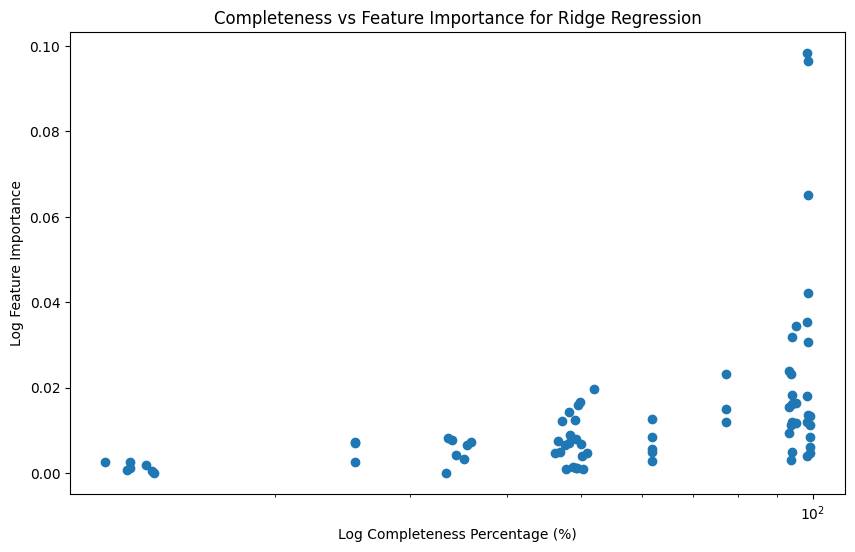

In [44]:
plt.figure(figsize=(10, 6))

# Choose the type of scale based on your preference or data distribution
plt.xscale('log')  # Use if feature importances span several orders of magnitude
# plt.yscale('log')  # Use if completeness percentages span several orders of magnitude


# Scatter plot of completeness vs feature importance
plt.scatter(completeness_percentage, feature_importances)

# Adding axis labels and title
plt.xlabel('Log Completeness Percentage (%)')
plt.ylabel('Log Feature Importance')
plt.title('Completeness vs Feature Importance for Ridge Regression')

# Show the plot
plt.show()

**Discussion**

The scatter plot depicting the relationship between feature completeness and feature importance for a Random Forest model shows that the majority of features possess relatively low importance, with a small subset displaying higher significance. This pattern suggests that only a select few features meaningfully influence the model's predictions regarding campaign response from transaction data. Most features, despite varying levels of completeness, do not strongly affect the outcome. It's notable that some features with higher importance scores are not necessarily the most complete, indicating that the model may be identifying nuanced patterns within the available data.

Improving the model could involve a strategic refinement of feature engineering and selection. The transactional nature of the data suggests that temporal dynamics could play a significant role in campaign response. Designing features that capture short-term fluctuations in transaction behavior, such as monthly spend trends, customer purchase cycles, or recent activity bursts, could provide more immediate insights into customer behavior than annual aggregates. Additionally, generating features that account for the frequency and recency of transactions could offer a more detailed depiction of customer engagement, which is often critical for predicting campaign response. Creating customer profiles based on purchase categories or historical response rates to past campaigns could further segment the customer base, potentially unveiling distinct patterns that can enhance prediction accuracy.

Incorporating external data that reflects broader consumer trends or economic indicators could also be beneficial, as such factors may indirectly influence campaign responsiveness. By widening the scope of features to include these external variables alongside more refined transaction-based metrics, the model could achieve a more holistic view of the factors influencing campaign outcomes. The addition of such features would ideally lead to a more robust model that not only leverages transactional history but also situates customer behavior within a broader context, potentially offering a marked improvement in predicting campaign response rates.